# Assignment Week 4 - Yihong Qiu Individual attempt

# Data Processing

### Import libraries

In [1]:
# main libraries
import pandas as pd
import numpy as np
from datetime import date
import geopy.distance
from math import sin, cos, sqrt, atan2, radians, log
from numpy import mean, where
from collections import Counter

# visual libraries
import seaborn as sns 
import matplotlib.pyplot as plt

# sklearn libraries
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.metrics import roc_curve,auc

# tensorflow libraries
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

### Read data

In [2]:
df_1 = pd.read_csv("../fraudTrain.csv")
df_2 = pd.read_csv("../fraudTest.csv")
fraud_df = df_1.append(df_2)

In [3]:
fraud_df.shape

(1852394, 23)

In [4]:
# Checking for missing values
fraud_df.isnull().any().sum()

0

In [5]:
# Checking for data types
fraud_df.dtypes

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

In [7]:
# Checking for unique values
fraud_df.nunique()

Unnamed: 0               1296675
trans_date_trans_time    1819551
cc_num                       999
merchant                     693
category                      14
amt                        60616
first                        355
last                         486
gender                         2
street                       999
city                         906
state                         51
zip                          985
lat                          983
long                         983
city_pop                     891
job                          497
dob                          984
trans_num                1852394
unix_time                1819583
merch_lat                1754157
merch_long               1809753
is_fraud                       2
dtype: int64

### Formatting and cleansing

In [ ]:
def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

def calculate_distance(row):
    coords_1 = (row['lat'], row['long'])
    coords_2 = (row['merch_lat'], row['merch_long'])
    return geopy.distance.geodesic(coords_1, coords_2).km

# Answer from https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
# The answers above are based on the Haversine formula, which assumes the earth is a sphere,
# which results in errors of up to about 0.5% (according to help(geopy.distance)). 
# Vincenty distance uses more accurate ellipsoidal models such as WGS-84, and is implemented in geopy. For example,
def calculate_distance2(row):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(row['lat'])
    lon1 = radians(row['long'])
    lat2 = radians(row['merch_lat'])
    lon2 = radians(row['merch_long'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    print(distance)


# First derive columns
if 'trans_date_trans_time' in fraud_df.columns:
    fraud_df['txn_datetime'] =  pd.to_datetime(fraud_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')

if 'dob' in fraud_df.columns:
    fraud_df['age'] = [calculate_age(d) for d in pd.to_datetime(fraud_df['dob'], format='%Y-%m-%d')]
    
if set(['lat', 'long', 'merch_lat', 'merch_long']).issubset(set(fraud_df.columns)):
     fraud_df['distance'] = [calculate_distance(row) for _, row in fraud_df.iterrows()]
        
fraud_df['hour'] = fraud_df['txn_datetime'].dt.hour
fraud_df['day'] = fraud_df['txn_datetime'].dt.day
fraud_df['month'] = fraud_df['txn_datetime'].dt.month
fraud_df['year'] = fraud_df['txn_datetime'].dt.year


In [ ]:
#Saving the new data frame since it take a while to create the new ones before after do the above steps and before the columns are dropped. 
fraud_df.to_csv('grp5_fraud_mod.csv')

In [8]:
#Read Modified Fraud File here to skip the feature generation...which can take a while
fraud_df = pd.read_csv("grp5_fraud_mod.csv")

In [9]:
# Drop the columns used to derive new features
fraud_df.drop([
    'Unnamed: 0',
    'Unnamed: 0.1',
    'trans_num',
    'trans_date_trans_time',
    'cc_num',
    'merchant',
    'unix_time',
    'first',
    'last',
    'street',
    'city',
    'state',
    'zip',
    'job',
    'dob',
    'lat',
    'long',
    'merch_lat',
    'merch_long',
    'txn_datetime'
], axis=1, errors='ignore', inplace=True)


In [10]:
fraud_df.head()

,category,amt,gender,city_pop,is_fraud,age,distance,hour,day,month,year
0,misc_net,4.97,F,3495,0,32,78.773821,0,1,1,2019
1,grocery_pos,107.23,F,149,0,42,30.216618,0,1,1,2019
2,entertainment,220.11,M,4154,0,58,108.102912,0,1,1,2019
3,gas_transport,45.00,M,1939,0,53,95.685115,0,1,1,2019
4,misc_pos,41.96,M,99,0,34,77.702395,0,1,1,2019


### Examining the class label imbalance

In [11]:
All = fraud_df.shape[0]
fraud = fraud_df[fraud_df['is_fraud'] == 1]
nonFraud = fraud_df[fraud_df['is_fraud'] == 0]

a = len(fraud)/All
b = len(nonFraud)/All

print('frauds :',round(a,2)*100,'%')
print('non frauds :',round(b,2)*100,'%')

frauds : 1.0 %
non frauds : 99.0 %


### Encoding

In [12]:
#create a list to hold our categorical columns and one to hold our numerical columns
cat_col = ['category','gender',]

#This one hot encodes the categorical columns and create a new variable to hold the nex column headers
if len(cat_col)>0: 
    cat_onehotencode = pd.get_dummies(fraud_df[cat_col],drop_first = True)
    cat_col_onehotencode = list(cat_onehotencode.columns)
    fraud_df = pd.concat([fraud_df,cat_onehotencode], axis = 1)

else:
    cat_col_onehotencode = []

In [13]:
fraud_df[cat_col_onehotencode].head()

,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [14]:
fraud_df = fraud_df.drop(['category','gender'],axis=1)

### Standardize the data

In [15]:
fraud_df.head()

,amt,city_pop,is_fraud,age,distance,hour,day,month,year,category_food_dining,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
0,4.97,3495,0,32,78.773821,0,1,1,2019,0,...,0,0,0,1,0,0,0,0,0,0
1,107.23,149,0,42,30.216618,0,1,1,2019,0,...,0,0,0,0,0,0,0,0,0,0
2,220.11,4154,0,58,108.102912,0,1,1,2019,0,...,0,0,0,0,0,0,0,0,0,1
3,45.00,1939,0,53,95.685115,0,1,1,2019,0,...,0,0,0,0,0,0,0,0,0,1
4,41.96,99,0,34,77.702395,0,1,1,2019,0,...,0,0,0,0,1,0,0,0,0,1


In [16]:
features = ['city_pop', 'age', 'distance', 'hour', 'day',
       'month', 'year', 'amt','category_food_dining',
       'category_gas_transport','category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       'gender_M']
target = ['is_fraud']
# Separating out the features
x = fraud_df.loc[:, features].values
# Separating out the target
y = fraud_df.loc[:,target].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

### Data splitting

In [17]:
count = len(fraud_df)
train = fraud_df[:count]
test = fraud_df[count:]
x = train.drop(['is_fraud'], axis=1)
y = train['is_fraud'].astype('int')
test = test.drop(['is_fraud'], axis=1)
x_train,x_test, y_train,y_test = train_test_split(x, y, test_size=0.3,random_state=123)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1296675, 22)
(1296675,)
(555719, 22)
(555719,)


## Neural Networks

### Define Keras Model

- Create a sequential model with layers.
- Input_dim is the number of variables.
- Dense class is the number of connected layers.
- The first hidden layer has 30 nodes and uses the relu activation function.
- The second hidden layer has 20 nodes and uses the relu activation function.
- The output layer has one node and uses the sigmoid activation function that ensures the output is between 0 and 1.

In [18]:
# define the keras model
model = Sequential()
model.add(Dense(30, input_dim=22, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                690       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


### Compile Keras Model

In [19]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Fit Keras Model

- The batch size is a number of samples processed before the model is updated. The size of a batch must be more than or equal to one and less than or equal to the number of samples in the training dataset.

- The number of epochs is the number of complete passes through the training dataset. 


In [30]:
# fit the keras model on the dataset
model.fit(x_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
40522/40522 [==============================] - 23s 569us/step - loss: 0.0227 - accuracy: 0.9958
Epoch 2/50
40522/40522 [==============================] - 23s 578us/step - loss: 0.0192 - accuracy: 0.9960
Epoch 3/50
40522/40522 [==============================] - 24s 591us/step - loss: 0.0219 - accuracy: 0.9960
Epoch 4/50
40522/40522 [==============================] - 23s 575us/step - loss: 0.0194 - accuracy: 0.9960
Epoch 5/50
40522/40522 [==============================] - 25s 608us/step - loss: 0.0189 - accuracy: 0.9961
Epoch 6/50
40522/40522 [==============================] - 23s 574us/step - loss: 0.0389 - accuracy: 0.9960
Epoch 7/50
40522/40522 [==============================] - 23s 567us/step - loss: 0.0196 - accuracy: 0.9960
Epoch 8/50
40522/40522 [==============================] - 23s 571us/step - loss: 0.0207 - accuracy: 0.9961
Epoch 9/50
40522/40522 [==============================] - 23s 566us/step - loss: 0.0211 - accuracy: 0.9962
Epoch 10/50
40522/40522 [============

### Evaluate Keras Model

In [31]:
# evaluate the keras model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print('Test loss: %.2f' % (test_loss*100))
print('Test accuracy: %.2f' % (test_accuracy*100))

17367/17367 [==============================] - 7s 391us/step - loss: 0.0167 - accuracy: 0.9966
Test loss: 1.67
Test accuracy: 99.66


### Predictions

In [32]:
# make probability predictions with the model
y_pred = model.predict(x_test)
# round predictions 
rounded = [round(x_test[0]) for x_test in y_pred]

In [33]:
# make class predictions with the model
y_pred = model.predict_classes(x_test)

In [34]:
# summarize the first 5 cases
#for i in range(5):
#    print('%s => %d (expected %d)' % (x_train[i].tolist(), y_pred[i], y_train[i]))

### ROC AUC Score


ROC AUC :  0.71


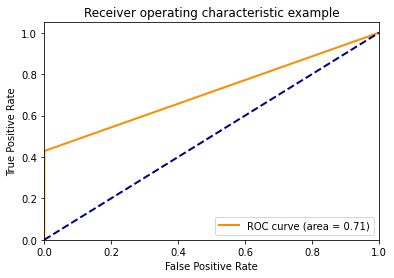

In [35]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('\nROC AUC : ', round(roc_auc,2))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

Confusion matrix : 
 [[552599    224]
 [  1654   1242]]
Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    552823
           1       0.85      0.43      0.57      2896

    accuracy                           1.00    555719
   macro avg       0.92      0.71      0.78    555719
weighted avg       1.00      1.00      1.00    555719



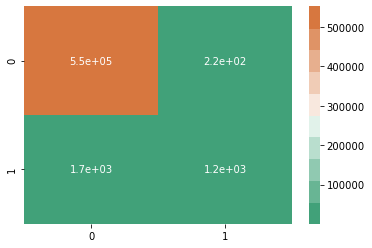

In [36]:
# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print('Confusion matrix : \n',matrix)

# classification report for precision, recall f1-score and accuracy
matrix1 = classification_report(y_test,y_pred)
print('Classification report : \n',matrix1)

cmap =  sns.diverging_palette(150, 30, s=80, l=60, n=10)
sns.heatmap(matrix, annot=True, cmap=cmap)
plt.show()

Reference

https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
    